In [1]:
import os
# Задаємо конкретну кулькість потоків, щоб не було утечкі пам'яті
NUM_THREADS = "1"
os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS


import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import cluster
import numpy as np

from kneed import KneeLocator

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances_argmin
from yellowbrick.cluster import KElbowVisualizer
scaler = StandardScaler()
min_max_scaler= MinMaxScaler()

sns.set(style="whitegrid")

In [2]:
# Функція із екзампла. Ця функція описуе k-means алгоритм
def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)]) 
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return centers, labels

In [3]:
# Функція із екзампла. Обираемо опимальну кількість кластерів.
def find_optimal_number_of_cluster(group, k_max):
    if type(group) == pd.core.frame.DataFrame:
        group = np.array(group.values.tolist())
    if type(group) == []:
         group = np.array(group)
    scaled_features = scaler.fit_transform(group)
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 150,
        "random_state": 42,
    }
    # A list holds the SSE values for each k
    sse = []
    for k in range(1,k_max):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    kl = KneeLocator(range(1, k_max), sse, curve="convex", direction="decreasing")
    return kl.elbow, sse

In [4]:
# В цій функціі пріменяемо всі попередні функції.
# Перше це нормалізуємо дані.
# Друге знаходимо оптимальну кількість кластерів, через функцію find_optimal_number_of_cluster
# Трете проводимо кластерізацію через метод find_clusters
def clustering(df, df_result, x, y):
    df_result = pd.DataFrame()
    df_normalized = normalize(df)
    if x != y and df[y].dtypes != object:
        group = df_normalized[[x, y]]
        X = np.array(group.values.tolist())
        NUM_CLUSTER, sse = find_optimal_number_of_cluster(X, 11)

        centers, labels = find_clusters(X, NUM_CLUSTER, rseed=0)
        key = x + "_" + y
        df_result[key] = labels
        df[key] = labels
        sns.scatterplot(data=df, x=x, y=y, alpha=0.8, c=labels, s=50, hue=labels) #выводим точечки
        sns.scatterplot(x=centers[:, 0], y=centers[:, 1],  s=250, zorder=2, marker="x", legend=None); #выводим центры
    return df_result

In [5]:
# Нормалізуемо дані.При помощі мін-макс-скалер уравніваем риси
def normalize(df):
    normalize = min_max_scaler.fit_transform(df)
    df_normalized = pd.DataFrame(normalize, columns=df.columns)
    return df_normalized

In [6]:
#Тепер можемо протестувати функціонал.
# Беремо наприклад стовбці child_mort та health
Y_label = "child_mort"
X_label = "health"
k_max = 11

raw_data = pd.read_csv('dataset/Country-data.csv')
df = raw_data.copy()
df.drop(columns=['country'],inplace=True)

In [7]:
# Нормалізуємо наші дані.
# Беремо зріз іксов та ігріків  і перекомпільовуемо їх в масив 
df_normalized_example = normalize(df.copy())
group = df_normalized_example[[X_label,Y_label]]
X = np.array(group.values.tolist())
NUMBER_CLUSTER, sse = find_optimal_number_of_cluster(df_normalized_example[[X_label,Y_label]], k_max)

In [8]:
# Починаємо розраховувати різними методами
# Перше це метод k-means.Які він працюе:
# Він рандомно знаходить центри, потім до ціх центрів підтягуе найближчі до центру точки, та формує кластер
KMeans_method = cluster.KMeans(init="k-means++", n_clusters=NUMBER_CLUSTER, n_init=10, random_state=24, max_iter=300) #K-Mean
labels_k_mean  = KMeans_method.fit(X).labels_
centers_k_mean = KMeans_method.fit(group).cluster_centers_

# Далі знаходимо кластери методом AlgoMax, він схожий на к-мінс
centers, labels = find_clusters(X, NUMBER_CLUSTER, rseed=0) #AlgoMax method

# Далі спектральний метод.
SpectralClustering_method = cluster.SpectralClustering(n_clusters=NUMBER_CLUSTER, affinity='nearest_neighbors', assign_labels='kmeans') #Spectral
labels_spectral = SpectralClustering_method.fit_predict(X)

# Далі метод дбСкан. Він розраховуе кластер на основі відстані між точками.
# Цей метод нам не дуже підходить, тому что у нас багато даних, та воні кучні. 
# І дбСкан всі точки або розподіляє до одніеї групи або визначає як шум
dbscan = cluster.DBSCAN(eps=0.25) #DBscan
scaled_features = scaler.fit_transform(group)
dbscan.fit(scaled_features)
labels_dbscan = dbscan.labels_

# Підписуємо графіки 
df_normalized_example['algo_max'] = labels
df_normalized_example['k-mean'] = labels_k_mean
df_normalized_example['spectral'] = labels_spectral
df_normalized_example['dbscan'] = labels_dbscan

Text(0.5, 0.98, 'Сomparison of different clasification methods X: health Y: child_mort')

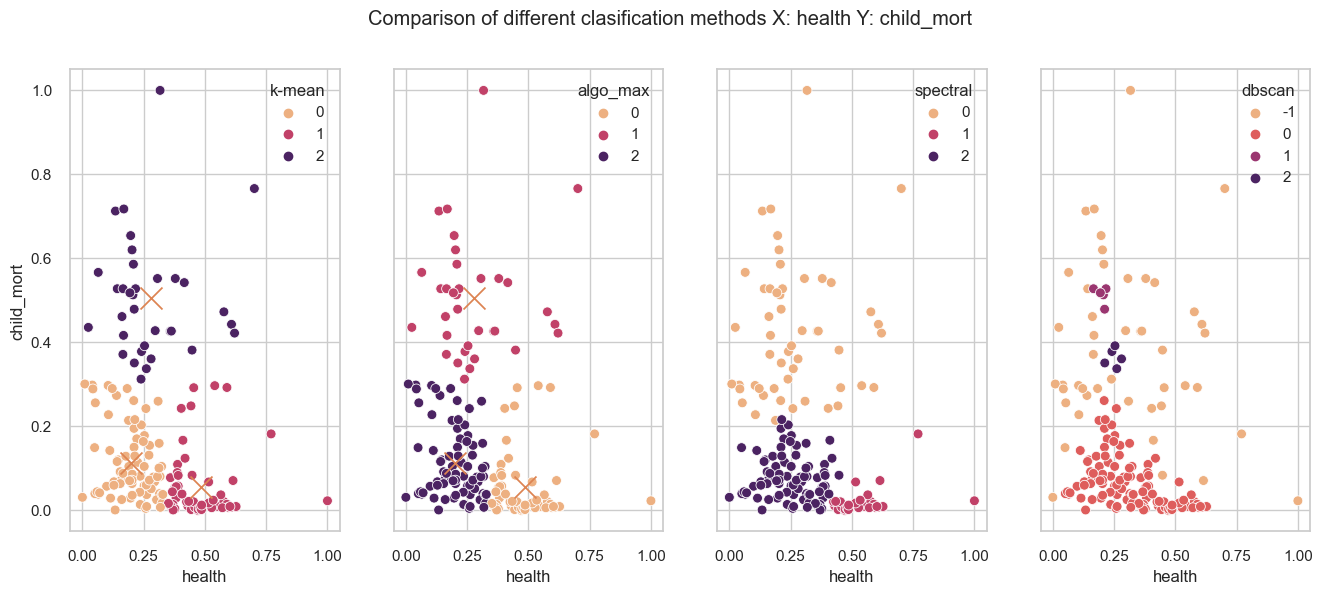

In [9]:
# Малюємо графіки
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 6), sharex=True, sharey=True)

# Визначаємо точки для k-means
sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="k-mean", s=50,alpha=1, palette="flare", ax=ax1)
# Визначаємо центри для k-means
sns.scatterplot(x=centers_k_mean[:, 0], y=centers_k_mean[:, 1], s=250, zorder=2, marker="x", ax=ax1, legend=None)

# Визначаємо точки для АлгоМакс
sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="algo_max", s=50,alpha=1, palette="flare", ax=ax2)
# Визначаємо центри для АлгоМакс
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], s=250, zorder=2, marker="x", ax=ax2, legend=None)

# Визначаємо точки для спектрального методу. Центрів у цього методу немає
sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="spectral", s=50,alpha=1, palette="flare", ax=ax3)

# Далі також визначаемо точки для дбСкан. Немає центрів.
sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="dbscan", s=50,alpha=1, palette="flare", ax=ax4)

fig.suptitle("Сomparison of different clasification methods X: {} Y: {}".format(X_label, Y_label))

Text(0.5, 1.0, 'Feature correlations')

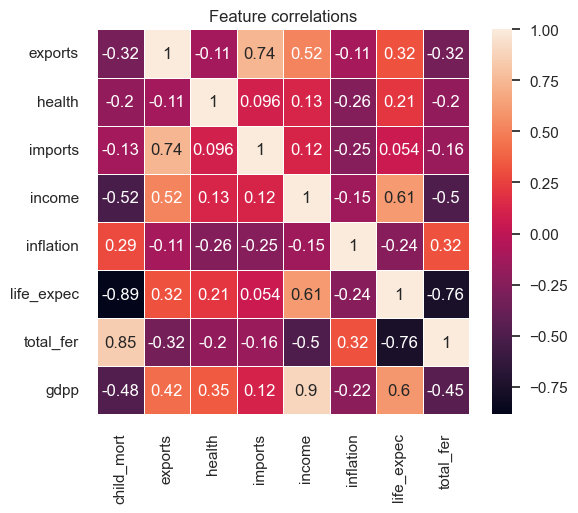

In [10]:
#Після того  як ми протестували методи, можемо працювати з даними
# Спочатку проводимо кореляцію.
# Створюемо хешмап
raw_data = pd.read_csv('dataset/Country-data.csv')
df = raw_data.copy()

cors = df.corr()

plt.figure(figsize=(6,5))

df_corr = df.corr().iloc[1:,:-1]
sns.heatmap(df_corr, annot=True, linewidth=0.4)
plt.title("Feature correlations")

In [11]:
#З карти кореляції ми бачимо наступне:

# - Як і очікувалось, ВВП та доходи населення мають високу кореляцію.
# Кількість народжених дітей на одну жінку сильно корелює з дитячою смертністю, що має сенс.
# -Імпорт та експорт, як і очікувалось, мають високу кореляцію.
# Тривалість життя сильно негативно корелює з дитячою смертністю.
# -Тривалість життя корелює з доходами
# -Тривалість життя корелює з ВВП
#Тривалість життя, сумарну народжуваність можна сміливо відкинути, 
# оскільки всі вони дуже сильно корелюють з іншими характеристиками.
# Країну теж відкидаємо, тому що це стрингові значення
df_clear = df.drop(columns = ['country', 'life_expec', 'total_fer']).copy()

In [12]:
#Проводимо нормалізацію наших даних
df_normalized = normalize(df_clear)

In [13]:
#Через K-mean знаходимо кластери
Y_label = "child_mort"
X_label = "health"
k_max = 11
group = df_normalized[[X_label,Y_label]]

In [14]:
NUMBER_CLUSTER, sse = find_optimal_number_of_cluster(group, k_max)

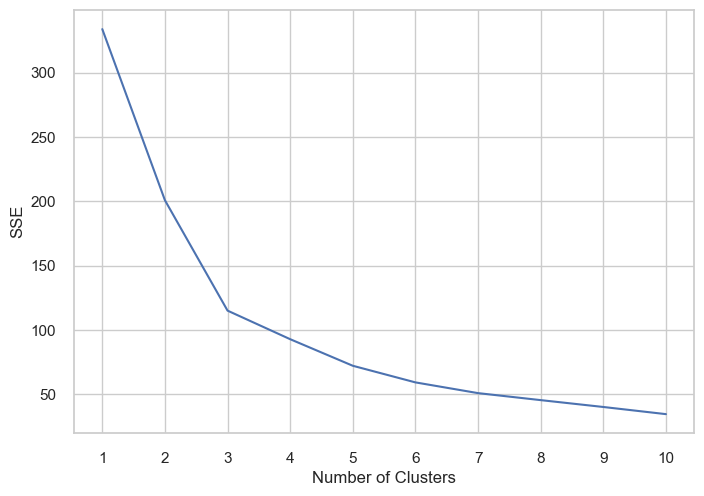

In [15]:
plt.plot(range(1, k_max), sse)
plt.xticks(range(1, k_max))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
# Як бачимо по графіку, самий різкий згиб бачимо на значенні 3. Значить наша оптимальна кількість кластерів - 3.

1    103
0     34
2     30
Name: gdpp_child_mort, dtype: int64

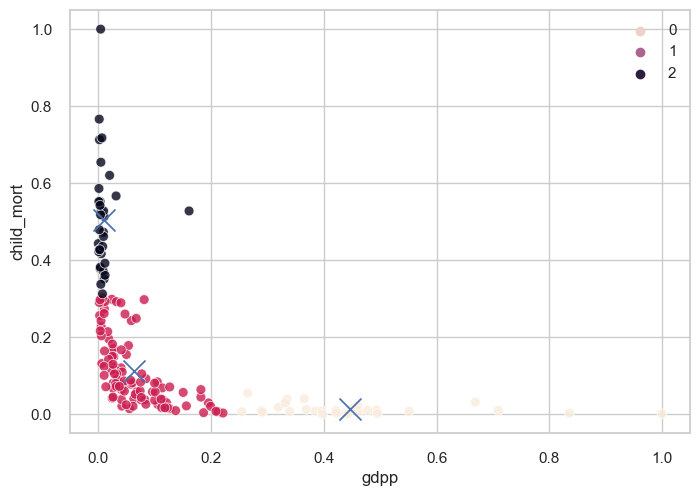

In [16]:
results = pd.DataFrame()
results = clustering(df_normalized, results, 'gdpp', 'child_mort')
results.gdpp_child_mort.value_counts()
# Будуємо графік по ВВП та child_mort
# Бачимо чорні кріїни у яких дуже низька ВВП, із за цього велика child_mort
# Червоні країни - більш меньше середній рівень с ВВП та child_mort
# А білі країни - велика ВВП дуже малий child_mort

1    86
0    51
3    25
2     5
Name: gdpp_imports, dtype: int64

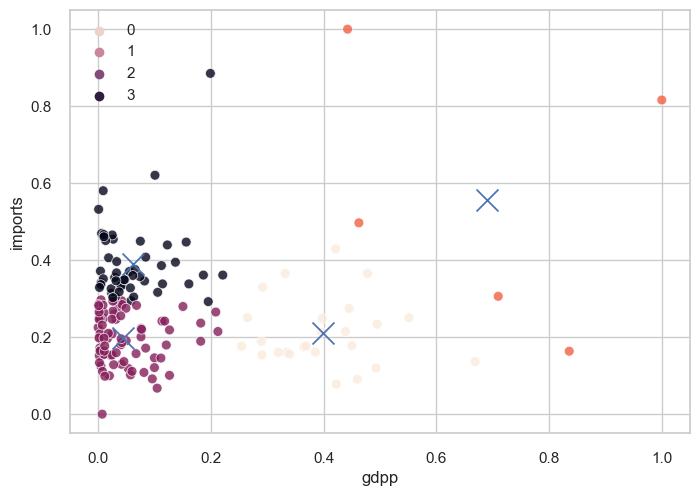

In [17]:
results = clustering(df_normalized, results, 'gdpp', 'imports')
results.gdpp_imports.value_counts()
# Робимо графік по ВВП та imports
# Маємо вже 4 кластера
# Бачимо що фіолетові та чорні більш меньше на одному рівні. Мають невелику ВВП та не багато imports
# Білі мають також середній рівень imports, але велику ВВП
# Оранжеві це такі країни як США, Китай, Швейцарія, у яких дуже великий imports та ВВП

1    98
0    47
2    22
Name: gdpp_health, dtype: int64

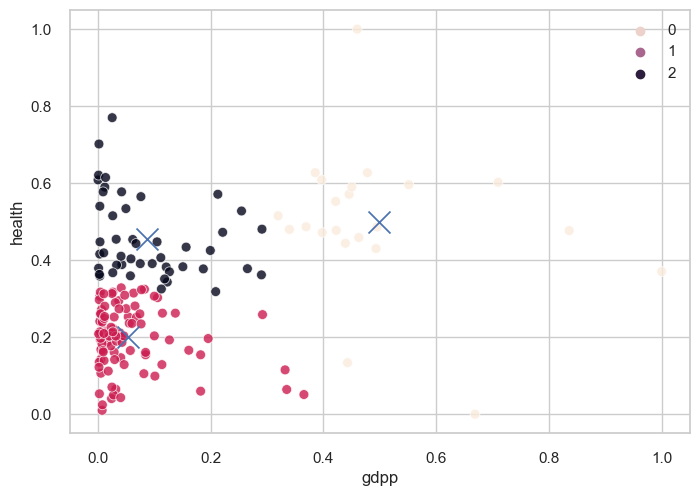

In [18]:
results = clustering(df_normalized, results, 'gdpp', 'health')
results.gdpp_health.value_counts()
# Далі будуємо графік по ВВП та health
# Маємо 3 кластери, але бачимо що ВВП не дуже впливає на health, тому что всі 3 кластери доходять тільки до половини по health

In [19]:
model = KMeans(n_clusters=4, random_state=123)
model.fit(df_normalized)

df['cluster'] = model.labels_
df.cluster.value_counts()
# Далі потрібно зробити однакову кількусть кластерів.
# Бачимо що в 0 кластері - 45 країн, в 1 - 30 країн, в 2 - 58 країн, в 3 - 34 країни

2    58
0    45
3    34
1    30
Name: cluster, dtype: int64

In [20]:
clusters = df.groupby(['cluster']).mean()
clusters
# Робимо групбай по середньому значенню, щоб побачити яка група стран найбідніша.
# Можемо зробити наступні висновки:
# в 3 кластері знаходиться найбідніша група стран, оскільки ці страни мють дуже великий показник дитячої смертності,
# та дуже малі показники ВВП та income
# В кластерах 2 і 0 ситуація вже краще, але теж ці страни мають низький ВВП та income
# В 1 кластері країни потребують допомогу в останню чергу, тому що там дуже великий income та ВВП, порівнюючи з іншими 
# кластерами. Та дуже малий показник дитячої смертності 

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
0,21.771111,54.295556,6.763778,67.473333,12568.888889,5.209533,71.464444,2.425111,7050.977778
1,5.226667,54.706667,8.911333,46.843333,48596.666667,2.754367,80.323333,1.810333,47053.333333
2,28.222414,31.392741,6.067586,33.085619,12691.724138,9.776224,72.156897,2.568621,6713.844828
3,106.402941,28.232941,6.311471,43.238235,3045.382353,12.220147,58.002941,5.290882,1374.029412


In [21]:
df[df.cluster==3].head(5)
# Одже, для того щоб надати директору компанії, 5 стран (із 3 кластеру), 
# яким допомога потрібна в першу чергу, виводимо назви цих стран

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.00,7.58,44.9,1610,9.440,56.2,5.82,553,3
3,Angola,119.0,62.30,2.85,42.9,5900,22.400,60.1,6.16,3530,3
17,Benin,111.0,23.80,4.10,37.2,1820,0.885,61.8,5.36,758,3
25,Burkina Faso,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575,3
26,Burundi,93.6,8.92,11.60,39.2,764,12.300,57.7,6.26,231,3


In [22]:
#df[df.cluster==2].head(58)